In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
from pathlib import Path
from pandas import Timestamp
from typing import Tuple, List
import numpy as np

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from cycler import cycler
from IPython.display import Image

# Import seaborn
#import seaborn as sns

import hillmaker as hm
from hillmaker.hmlib import pctile_field_name
from hillmaker.plotting import make_week_hill_plot

## Matplotlib styling review

What does a plot look like with the default style.

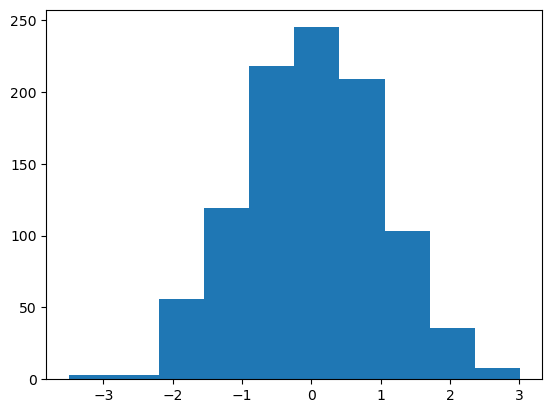

In [17]:
plt.hist(np.random.randn(1000));

Make a copy of the current `rcParams`. These are the defaults for matplotlib since I haven't set any style related things.

In [4]:
jupyter_default = plt.rcParams.copy()



There's several hundred so I commented out the following.

In [22]:
jupyter_default

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
   

`jupyter_default` is a dictionary.

In [6]:
jupyter_default['axes.edgecolor']

'black'

In [7]:
jupyter_default['axes.grid']

False

Individual properties of the underlying style can be changed like this.

In [30]:
plt.rcParams['axes.grid'] = True

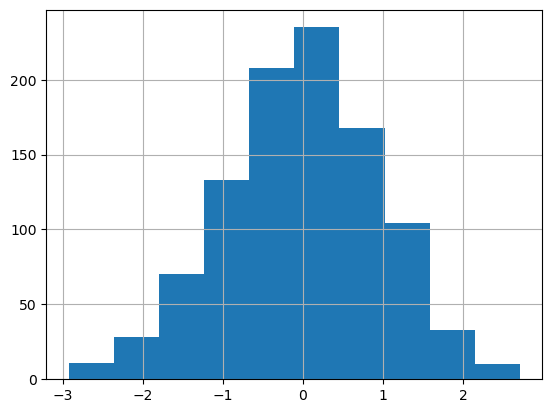

In [32]:
plt.hist(np.random.randn(1000));
# reset to to default
plt.rcParams['axes.grid'] = False

There's an `rc` convenience function for setting a bunch of properties for a *group*. The following example (from JVP) shows how to also use the color cycler to change colors of lines (and the bars in a histogram).

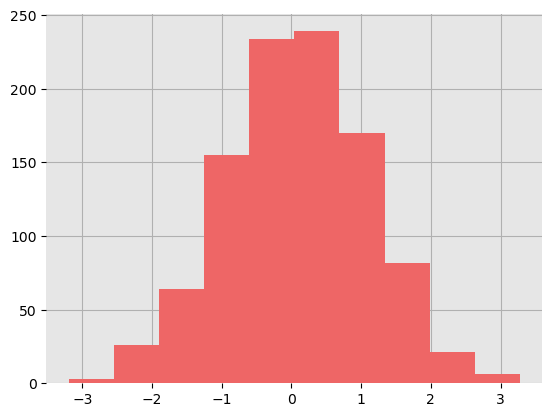

In [36]:
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)

plt.hist(np.random.randn(1000));

In [37]:
plt.rcParams['axes.grid']

True

Let's undo all those changes and get things back to default style. I think both of the following accomplish the same thing.

```
plt.rcdefaults()
# The following also seems to do the same thing
plt.style.use('default')


```

In [38]:
#plt.style.use('default')
plt.rcdefaults()
plt.rcParams['axes.grid']

False

We can use a context manager to temporarily get or set plot style related parameters.

In [21]:
# Get a few properties for ggplot style
with plt.style.context('ggplot'):
    print(f'ggplot axes.grid = {plt.rcParams["axes.grid"]}')
    print(f'ggplot axes.edgecolor = {plt.rcParams["axes.edgecolor"]}')
    
# Now print same properties for default style
print(f'default axes.grid = {plt.rcParams["axes.grid"]}')
print(f'default axes.edgecolor = {plt.rcParams["axes.edgecolor"]}')

ggplot axes.grid = True
ggplot axes.edgecolor = white
default axes.grid = False
default axes.edgecolor = black


You can also use matplotlib style files to modify specific properties of the currently active style. Such a file looks like this. I got this example from this blog post - https://www.hfstevance.com/blog/2019/7/22/matplotlib-style.

```
# To check more avaialble options see:
# https://matplotlib.org/tutorials/introductory/customizing.html

text.color : (0.2,0.2,0.2)

# AXES
axes.titlesize : 16
axes.labelsize : 14
axes.edgecolor : (0.1,0.1,0.1) #Normalized RGB colours (from 0 to 1 instead of 0 to 255)
axes.labelcolor : (0.1,0.1,0.1)
axes.linewidth : 1
axes.spines.top : False
axes.spines.right : False
axes.spines.bottom : True
axes.spines.left : True

# GRID
axes.grid : True
grid.alpha : 0.7
grid.linestyle : --
grid.linewidth : 0.6

# LINES
axes.prop_cycle : cycler('color', [ '0046b8', '2464c9', '4d87e3', '7899cf', '8ea1bf']) #hex colours
lines.linewidth : 1.5
lines.markeredgewidth : 0.0

# SCATTER PLOT
scatter.marker : .

# TICKS
xtick.labelsize : 13
xtick.color : (0.2,0.2,0.2)
xtick.direction : in
ytick.labelsize : 13
ytick.color : (0.2,0.2,0.2)
ytick.direction : in

# FIGURE OUTPUT 
figure.figsize  : 7, 5
figure.dpi : 150
savefig.dpi : 200
```

In [42]:
mpl.rc_file('example.mplstyle')

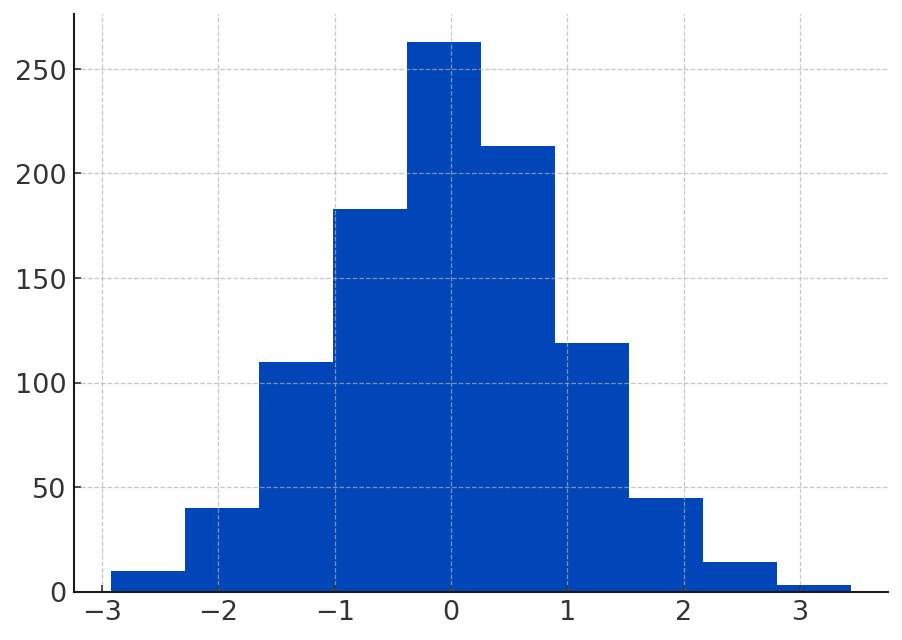

In [43]:
plt.hist(np.random.randn(1000));

Reset defaults.

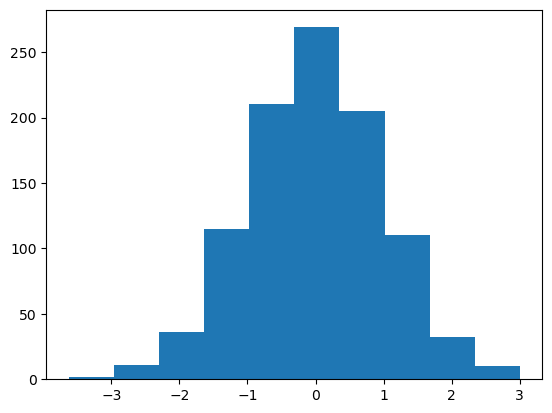

In [44]:
plt.rcdefaults()
plt.hist(np.random.randn(1000));

So, given all of the above and much more in the matplotlib docs on styling at https://matplotlib.org/stable/tutorials/introductory/customizing.html#sphx-glr-tutorials-introductory-customizing-py, we need to decide how to implement plot styling in hillmaker. Some random thoughts:

1. We could design some default plots and store the styling parameters in style sheet files. 
2. I've already added some additional style related input parameters to `make_week_hill_plot()` and will do same for any plot related scenario methods (which will likely just be wrappers around the module level `make_week_hill_plot()` function.
3. Power users can always make style changes after creating plot.

## Run hillmaker

In [45]:
ssu_stopdata = '../data/ShortStay.csv'
ssu_stops_df = pd.read_csv(ssu_stopdata, parse_dates=['InRoomTS','OutRoomTS'])
ssu_stops_df.info() # Check out the structure of the resulting DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59877 entries, 0 to 59876
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   PatID      59877 non-null  int64         
 1   InRoomTS   59877 non-null  datetime64[ns]
 2   OutRoomTS  59877 non-null  datetime64[ns]
 3   PatType    59877 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 1.8+ MB


In [46]:
# Required inputs
scenario_name = 'ssu_1'
stops_df = ssu_stops_df
in_field_name = 'InRoomTS'
out_field_name = 'OutRoomTS'
start_date = '1996-01-01'
end_date = '1996-09-30'

# Optional inputs

cat_field_name = 'PatType'
verbosity = 1 # INFO level logging
output_path = './output'
bin_size_minutes = 60

s1 = hm.Scenario(scenario_name=scenario_name, 
                         stops_df=stops_df,
                         in_field=in_field_name,
                         out_field=out_field_name,
                         start_analysis_dt=start_date,
                         end_analysis_dt=end_date,
                         cat_field=cat_field_name,
                         output_path=Path('./output'),
                         verbosity=verbosity)

In [47]:
s1.make_hills()

2023-09-07 13:13:14,844 - hillmaker.bydatetime - INFO - min of intime: 1996-01-01 07:44:00
2023-09-07 13:13:14,845 - hillmaker.bydatetime - INFO - max of intime: 1996-09-29 19:51:00
2023-09-07 13:13:14,847 - hillmaker.bydatetime - INFO - min of outtime: 1996-01-01 08:50:00
2023-09-07 13:13:14,847 - hillmaker.bydatetime - INFO - max of outtime: 1996-09-29 20:15:00
2023-09-07 13:13:14,849 - hillmaker.bydatetime - INFO - start analysis: 1996-01-01, end analysis: 1996-09-30
2023-09-07 13:13:14,871 - hillmaker.bydatetime - INFO - min of entry time_bin = 7
2023-09-07 13:13:14,873 - hillmaker.bydatetime - INFO - max of exit time_bin = 6546 and num_bins=6553
2023-09-07 13:13:15,571 - hillmaker.bydatetime - INFO - cat IVT {'inner': 33019}
2023-09-07 13:13:15,615 - hillmaker.bydatetime - INFO - cat IVT num_arrivals_hm 33019 num_arrivals_stops 33019
2023-09-07 13:13:15,616 - hillmaker.bydatetime - INFO - cat IVT num_departures_hm 33019 num_departures_stops 33019
2023-09-07 13:13:15,619 - hillmake

By default, the `get_summary_df` method will return the summary by category. It would be nice to design a stacked bar plot based on this dataframe. 

- the means would be the stacked bars
- for the percentiles, we need to use the summary df that is for the total (i.e. not by category).

In [49]:
occ_summary_cat_df = s1.get_summary_df()
occ_summary_cat_df

count  mean  min  max  \
PatType day_of_week dow_name bin_of_day bin_of_day_str                          
ART     0           Mon      0          00:00            40.0   0.0  0.0  0.0   
                             1          01:00            39.0   0.0  0.0  0.0   
                             2          02:00            39.0   0.0  0.0  0.0   
                             3          03:00            39.0   0.0  0.0  0.0   
                             4          04:00            39.0   0.0  0.0  0.0   
...                                                       ...   ...  ...  ...   
OTH     6           Sun      19         19:00            39.0   0.0  0.0  0.0   
                             20         20:00            39.0   0.0  0.0  0.0   
                             21         21:00            39.0   0.0  0.0  0.0   
                             22         22:00            39.0   0.0  0.0  0.0   
                             23         23:00            39.0   0.0  0.0  0.0   

                                                        stdev  sem  var   cv  \
PatType day_of_week dow_name bin_of_day bin_of_day_str                         
ART     0           Mon      0          00:00             0.0  0.0  0.0  0.0   
                             1          01:00             0.0  0.0  0.0  0.0   
                             2          02:00             0.0  0.0  0.0  0.0   
                             3          03:00             0.0  0.0  0.0  0.0   
                             4          04:00             0.0  0.0  0.0  0.0   
...                                                       ...  ...  ...  ...   
OTH     6           Sun      19         19:00             0.0  0.0  0.0  0.0   
                             20         20:00             0.0  0.0  0.0  0.0   
                             21         21:00             0.0  0.0  0.0  0.0   
                             22         22:00             0.0  0.0  0.0  0.0   
                             23         23:00             0.0  0.0  0.0  0.0   

                                                        skew  kurt  p25  p50  \
PatType day_of_week dow_name bin_of_day bin_of_day_str                         
ART     0           Mon      0          00:00            0.0   0.0  0.0  0.0   
                             1          01:00            0.0   0.0  0.0  0.0   
                             2          02:00            0.0   0.0  0.0  0.0   
                             3          03:00            0.0   0.0  0.0  0.0   
                             4          04:00            0.0   0.0  0.0  0.0   
...                                                      ...   ...  ...  ...   
OTH     6           Sun      19         19:00            0.0   0.0  0.0  0.0   
                             20         20:00            0.0   0.0  0.0  0.0   
                             21         21:00            0.0   0.0  0.0  0.0   
                             22         22:00            0.0   0.0  0.0  0.0   
                             23         23:00            0.0   0.0  0.0  0.0   

                                                        p75  p95  p99  
PatType day_of_week dow_name bin_of_day bin_of_day_str                 
ART     0           Mon      0          00:00           0.0  0.0  0.0  
                             1          01:00           0.0  0.0  0.0  
                             2          02:00           0.0  0.0  0.0  
                             3          03:00           0.0  0.0  0.0  
                             4          04:00           0.0  0.0  0.0  
...                                                     ...  ...  ...  
OTH     6           Sun      19         19:00           0.0  0.0  0.0  
                             20         20:00           0.0  0.0  0.0  
                             21         21:00           0.0  0.0  0.0  
                             22         22:00           0.0  0.0  0.0  
                             23         23:00           

To get the overall summary stats, we pass `by_category=False` when calling the `get_summary_df` method. 

**QUESTION** Of course, we could flip the default here. What do you think?

In [50]:
occ_summary_df = s1.get_summary_df(by_category=False)
occ_summary_df[25:40]

count       mean        min  \
day_of_week dow_name bin_of_day bin_of_day_str                                
1           Tue      1          01:00            39.0   0.202991   0.000000   
                     2          02:00            39.0   0.146581   0.000000   
                     3          03:00            39.0   0.096581   0.000000   
                     4          04:00            39.0   0.092308   0.000000   
                     5          05:00            39.0   0.175641   0.000000   
                     6          06:00            39.0   2.454274   1.000000   
                     7          07:00            39.0  19.416239  12.666667   
                     8          08:00            39.0  27.877778  20.333333   
                     9          09:00            39.0  22.536325  10.816667   
                     10         10:00            39.0  32.497436  22.733333   
                     11         11:00            39.0  38.423077  27.350000   
                     12         12:00            39.0  39.510684  25.400000   
                     13         13:00            39.0  36.269231  25.350000   
                     14         14:00            39.0  31.405128  23.616667   
                     15         15:00            39.0  27.542308  19.583333   

                                                      max     stdev       sem  \
day_of_week dow_name bin_of_day bin_of_day_str                                  
1           Tue      1          01:00            1.333333  0.375022  0.060052   
                     2          02:00            1.466667  0.323703  0.051834   
                     3          03:00            0.750000  0.219755  0.035189   
                     4          04:00            1.000000  0.227491  0.036428   
                     5          05:00            1.300000  0.334992  0.053642   
                     6          06:00            5.000000  1.077486  0.172536   
                     7          07:00           24.083333  2.559290  0.409814   
                     8          08:00           33.283333  3.198180  0.512119   
                     9          09:00           30.116667  4.187706  0.670570   
                     10         10:00           39.150000  4.065801  0.651049   
                     11         11:00           49.066667  4.710699  0.754315   
                     12         12:00           49.666667  5.157644  0.825884   
                     13         13:00           42.983333  5.319737  0.851840   
                     14         14:00           38.450000  3.858078  0.617787   
                     15         15:00           38.216667  3.890403  0.622963   

                                                      var        cv      skew  \
day_of_week dow_name bin_of_day bin_of_day_str                                  
1           Tue      1          01:00            0.140641  1.847476  1.931038   
                     2          02:00            0.104783  2.208350  2.610424   
                     3          03:00            0.048292  2.275336  2.126966   
                     4          04:00            0.051752  2.464485  2.676122   
                     5          05:00            0.112220  1.907257  1.878066   
                     6          06:00            1.160975  0.439024  0.820301   
                     7          07:00            6.549963  0.131812 -0.426090   
                     8          08:00           10.228353  0.114721 -0.647689   
                     9          09:00           17.536884  0.185820 -0.672795   
                     10         10:00           16.530739  0.125111 -0.450546   
                     11         11:00           22.190682  0.122601 -0.535508   
                     12         12:00           26.601294  0.130538 -0.544897   
                     13         13:00           28.299599  0.146674 -0.631588   
                     14         14:00           14.884768  0.122849 -0.064790   
                     15       

## Plotting

I created a module level function called `make_week_hill_plot` that just focuses on making the weekly plot. I added a bunch of functionality to make it easier for user to customize the plot contents and style.

- `plot_style` can be specified. Right now the default is 'ggplot' but we can change that.
- Figure size can be set via `figsize=`
- The bar colors can be set via `bar_color_mean=`
- which percentiles plotted and their color and linestyles can be specified via `percentiles`, `pctile_color`, `pctile_linestyle`, and `pctile_linewidth`.
- The super title can be set with `suptitle=`
- Additional style parameters related to `suptitle` can be specified with the `suptitle_properties=` dictionary
- Similar input args are available for the `title`.
- Legend properties can be set via `legend_properties=` dictionary
- A capacity line and its color can be set via `cap=` and `cap_color=`


In [55]:
plot = make_week_hill_plot(summary_df=occ_summary_df, scenario_name='plot_test', metric='occupancy',
                        bin_size_minutes=60,
                        cap=52,
                        cap_color='green',
                        plot_style='ggplot',
                        figsize=(15, 10),
                        bar_color_mean='steelblue',
                        percentiles=(0.95, 0.75),
                        pctile_color=('black', 'grey'),
                        pctile_linestyle=('-', '-.'),
                        pctile_linewidth=(.75, .75), 
                        suptitle='Weekly occupancy summary',
                        suptitle_properties={'x': 0.125, 'y': 0.95, 'horizontalalignment': 'left', 'verticalalignment': 'top', 'fontsize': 16},
                        title='Overall occupancy',
                        title_properties={'loc': 'left', 'style': 'italic'},
                        legend_properties={'loc': 'best', 'frameon': True, 'facecolor': 'w'},
                        xlabel='Hour',
                        ylabel='Patients',
                        export_path='./output')

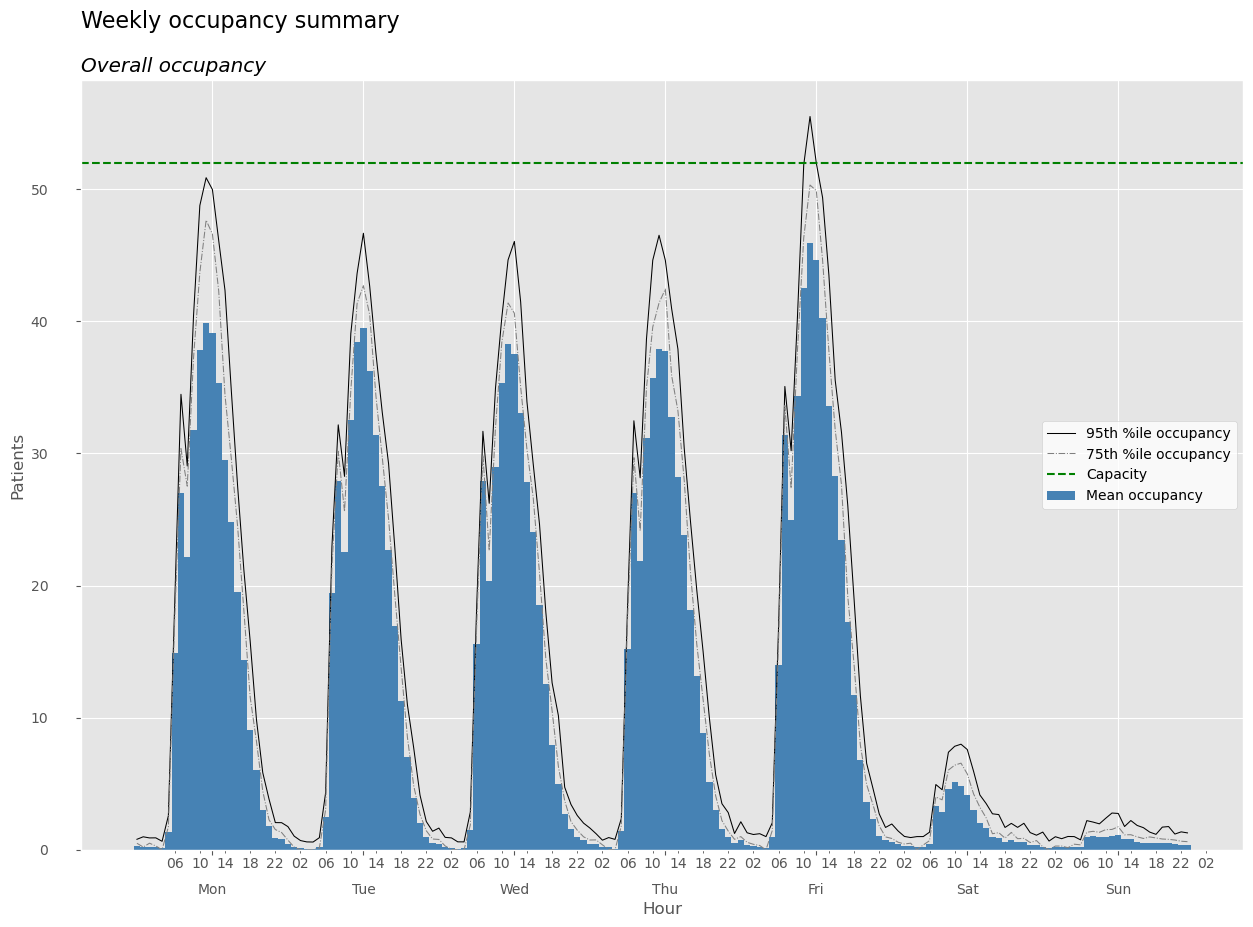

In [56]:
plot

All the plot styling in the previos plot was set within a context manager in `make_week_hill_plot()`. So, seems like style should now revert to default. But maybe notebooks are funny.

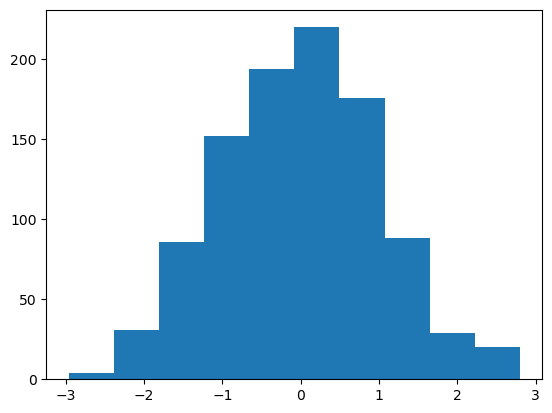

In [58]:
plt.hist(np.random.randn(1000));

Yep, it's still the default. Great, the context manager code is working.

## First dow - IGNORE

Working on making first DOW settable for plot.

In [ ]:
def find_first_dow(year, month, dow):
    d = Timestamp(year, month, 1)
    offset = -d.weekday() #weekday = 0 means monday
    return d + timedelta(offset)

In [ ]:
year = 2015
month = 1
dow = 0

d = Timestamp(year, month, 1)
d

In [ ]:
dow_1 = d.weekday()
dow_1

In [ ]:
d + pd.Timedelta(7, unit="d") - pd.Timedelta(dow_1, unit="d")

In [ ]:
(d + pd.Timedelta(7, unit="d") - pd.Timedelta(dow_1, unit="d")).weekday()

In [ ]:
(d + pd.Timedelta(7, unit="d") - pd.Timedelta(dow_1, unit="d")).weekday()